In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import statsmodels.api as sm

#1. Load and Process Data

In [ ]:
# Load the dataset

try:
    # Load the dataset
    df = pd.read_csv("employee_attrition_data.csv")
except FileNotFoundError:
    raise FileNotFoundError(
        "Dataset not found. Please ensure 'employee_attrition_data.csv' "
        "is located in the same directory as this notebook."
    )
except Exception as e:
    raise RuntimeError(f"An unexpected error occurred while loading the data: {e}")

# Keep only relevant variables
df = df[[
    'Age', 'MonthlyIncome', 'OverTime', 'JobSatisfaction',
    'WorkLifeBalance', 'JobInvolvement',
    'YearsAtCompany', 'YearsSinceLastPromotion', 'Attrition'
]]

# Data overview
print(f"1) Dataset shape: {df.shape}\n")
print(f"2) Data overview: \n{df.head()}\n")

# Data types & missing values
print(f"3a) Data types:\n{df.dtypes}\n")
print("3b) Count of missing values:\n", df.isna().sum(),"\n")

# Drop rows with missing values
df_clean = df.dropna()

# Convert categorical variables to dummy variables
df_clean = pd.get_dummies(df_clean, columns = ['OverTime','Attrition'], drop_first = True, dtype = int)

print("4) Cleaned and encoded dataset:")
df_clean.head()

1) Dataset shape: (1470, 9)

2) Data overview: 
   Age  MonthlyIncome OverTime  JobSatisfaction  WorkLifeBalance  \
0   41           5993      Yes                4                1   
1   49           5130       No                2                3   
2   37           2090      Yes                3                3   
3   33           2909      Yes                3                3   
4   27           3468       No                2                3   

   JobInvolvement  YearsAtCompany  YearsSinceLastPromotion Attrition  
0               3               6                        0       Yes  
1               2              10                        1        No  
2               2               0                        0       Yes  
3               3               8                        3        No  
4               3               2                        2        No  

3a) Data types:
Age                         int64
MonthlyIncome               int64
OverTime                   objec

,Age,MonthlyIncome,JobSatisfaction,WorkLifeBalance,JobInvolvement,YearsAtCompany,YearsSinceLastPromotion,OverTime_Yes,Attrition_Yes
0,41,5993,4,1,3,6,0,1,1
1,49,5130,2,3,2,10,1,0,0
2,37,2090,3,3,2,0,0,1,1
3,33,2909,3,3,3,8,3,1,0
4,27,3468,2,3,3,2,2,0,0


In [ ]:
# Summary statistics
print("Summary statistics:\n", df_clean.describe().T, "\n")

Summary statistics:
                           count         mean          std     min     25%  \
Age                      1470.0    36.923810     9.135373    18.0    30.0   
MonthlyIncome            1470.0  6502.931293  4707.956783  1009.0  2911.0   
JobSatisfaction          1470.0     2.728571     1.102846     1.0     2.0   
WorkLifeBalance          1470.0     2.761224     0.706476     1.0     2.0   
JobInvolvement           1470.0     2.729932     0.711561     1.0     2.0   
YearsAtCompany           1470.0     7.008163     6.126525     0.0     3.0   
YearsSinceLastPromotion  1470.0     2.187755     3.222430     0.0     0.0   
OverTime_Yes             1470.0     0.282993     0.450606     0.0     0.0   
Attrition_Yes            1470.0     0.161224     0.367863     0.0     0.0   

                            50%     75%      max  
Age                        36.0    43.0     60.0  
MonthlyIncome            4919.0  8379.0  19999.0  
JobSatisfaction             3.0     4.0      4.0  
Work

#2. Numerical Relationships Between Variables

In [ ]:
# Correlation matrix (all correlations)
corr_matrix = df_clean.corr()
print("Correlation Matrix: All Correlations\n\n", corr_matrix)

Correlation Matrix: All Correlations

                               Age  MonthlyIncome  JobSatisfaction  \
Age                      1.000000       0.497855        -0.004892   
MonthlyIncome            0.497855       1.000000        -0.007157   
JobSatisfaction         -0.004892      -0.007157         1.000000   
WorkLifeBalance         -0.021490       0.030683        -0.019459   
JobInvolvement           0.029820      -0.015271        -0.021476   
YearsAtCompany           0.311309       0.514285        -0.003803   
YearsSinceLastPromotion  0.216513       0.344978        -0.018214   
OverTime_Yes             0.028062       0.006089         0.024539   
Attrition_Yes           -0.159205      -0.159840        -0.103481   

                         WorkLifeBalance  JobInvolvement  YearsAtCompany  \
Age                            -0.021490        0.029820        0.311309   
MonthlyIncome                   0.030683       -0.015271        0.514285   
JobSatisfaction                -0.019459  

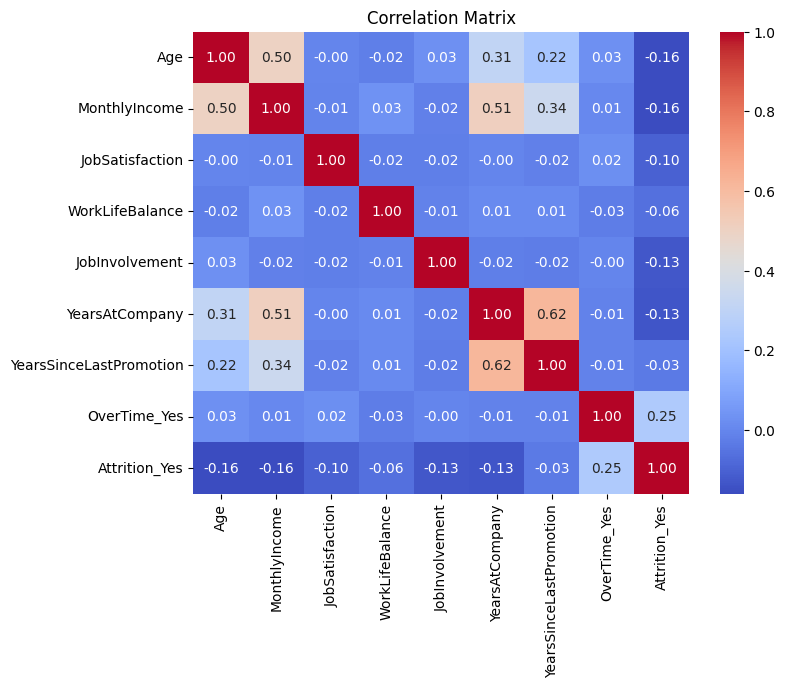

In [ ]:
# Heatmap of correlations
plt.figure(figsize =(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Our correlation analysis shows that overtime has the strongest positive association with employee attrition (ρ = 0.25), indicating that workload pressure is a key risk factor. The MonthlyIncome, YearsAtCompany, and JobInvolvement variables show moderate negative correlations with attrition. While some predictors show moderate multicollinearity, such as YearsAtCompany and YearsSinceLastPromotion (p = 0.62), no relationships exceed commonly accepted multicollinearity thresholds.

#3. Logistic Regression Model

In [ ]:
# Logistic regression is used to quantify the marginal impact
# of workplace factors on the probability of employee attrition.

# Define X (features) and y (target)
X = df_clean.drop(columns = ['Attrition_Yes'])
y = df_clean['Attrition_Yes']

# Add constant for intercept
X_const = sm.add_constant(X)

# Fit the full logistic regression model
logit_full = sm.Logit(y, X_const).fit()
print(logit_full.summary())

# Compute odds ratios
odds_ratios = np.exp(logit_full.params)
print("\nOdds Ratios:\n", odds_ratios)

# Identify statistically strong predictors (p < 0.05)
print("\nSignificant Predictors (p < 0.05):")
sig = logit_full.pvalues[logit_full.pvalues < 0.05]
print(sig)

# Build a reduced model including only significant predictors (except the intercept)
significant_vars = list(sig.index)
significant_vars = [var for var in significant_vars if var != "const"]

X_reduced = sm.add_constant(X[significant_vars])

logit_reduced = sm.Logit(y, X_reduced).fit()
print("\nReduced Model Summary:\n")
print(logit_reduced.summary())

# Odds ratios for reduced model
odds_ratios_reduced = np.exp(logit_reduced.params)
print("\nReduced Model Odds Ratios:\n", odds_ratios_reduced)

Optimization terminated successfully.
         Current function value: 0.369661
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          Attrition_Yes   No. Observations:                 1470
Model:                          Logit   Df Residuals:                     1461
Method:                           MLE   Df Model:                            8
Date:                Thu, 18 Dec 2025   Pseudo R-squ.:                  0.1631
Time:                        21:38:10   Log-Likelihood:                -543.40
converged:                       True   LL-Null:                       -649.29
Covariance Type:            nonrobust   LLR p-value:                 2.096e-41
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       2.7061      0.560      4.831      0.000       1.608   

#4. Prediction & Accuracy for Logistic Regression

In [ ]:
# Predicted probabilities using the reduced model
y_prob = logit_reduced.predict(X_reduced)

# Convert probabilities to class predictions (cutoff = 0.5)
y_pred = (y_prob >= 0.5).astype(int)

# Compute accuracy
accuracy = accuracy_score(y, y_pred)
print("Logistic Regression Accuracy:", accuracy)

# Confusion matrix
cm = confusion_matrix(y, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification report (precision, recall, F1)
print("\nClassification Report:")
print(classification_report(y, y_pred))

# Sensitivity (Recall for class = 1) and Specificity (Recall for class = 0)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)   # True Positive Rate
specificity = tn / (tn + fp)   # True Negative Rate

print("Sensitivity (Recall for Reaction=1):", sensitivity)
print("Specificity (Recall for Reaction=0):", specificity)

Logistic Regression Accuracy: 0.8530612244897959

Confusion Matrix:
[[1212   21]
 [ 195   42]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1233
           1       0.67      0.18      0.28       237

    accuracy                           0.85      1470
   macro avg       0.76      0.58      0.60      1470
weighted avg       0.83      0.85      0.82      1470

Sensitivity (Recall for Reaction=1): 0.17721518987341772
Specificity (Recall for Reaction=0): 0.9829683698296837


While the model achieves an overall accuracy of 85.3%, this metric is influenced by the class imbalance inherent in employee attrition data. The model demonstrates high specificity (98.3%), indicating strong performance in correctly identifying employees who remain with the organization. Sensitivity is lower (17.7%), suggesting the model is conservative in flagging attrition risk. Importantly, when the model does predict attrition, it is correct 67% of the time, making it well-suited for targeted retention interventions rather than broad screening.

#5. Decision Tree Model

In [ ]:
# Decision tree is used as a non-linear benchmark model
# to capture interaction effects and feature importance.

# Define X and y from the cleaned attrition dataset
y_ml = df_clean["Attrition_Yes"]
X_ml = df_clean.drop(columns = ["Attrition_Yes"])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_ml, y_ml, test_size = 0.3, random_state = 352, stratify = y_ml
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Build the decision tree classifier
tree_model = DecisionTreeClassifier(
    max_depth = 4, # keeps tree interpretable and prevents overfitting
    random_state = 352
)

# Fit the model
tree_model.fit(X_train, y_train)

print("\nDecision Tree Model Trained Successfully.")

Training set size: (1029, 8)
Test set size: (441, 8)

Decision Tree Model Trained Successfully.



Feature Importances (Highest → Lowest):
MonthlyIncome              0.330238
Age                        0.202249
OverTime_Yes               0.194137
YearsAtCompany             0.129304
YearsSinceLastPromotion    0.063580
JobInvolvement             0.055914
WorkLifeBalance            0.024579
JobSatisfaction            0.000000
dtype: float64


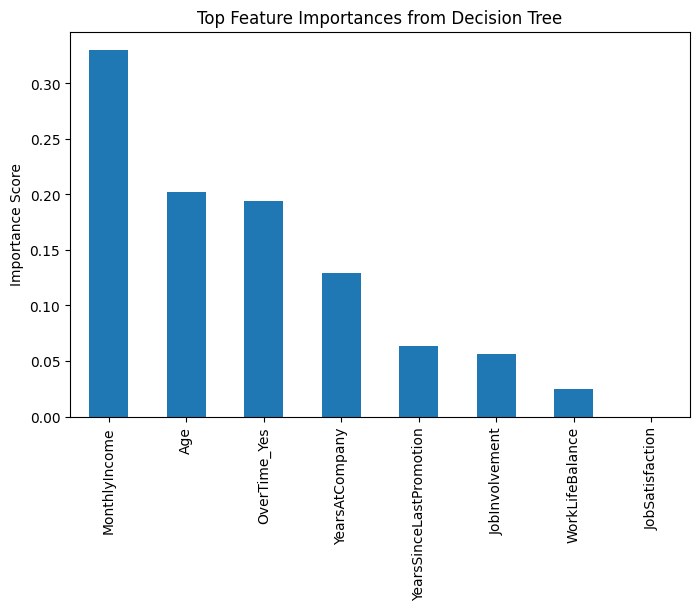

In [ ]:
importances = pd.Series(tree_model.feature_importances_, index=X_ml.columns)
importances_sorted = importances.sort_values(ascending=False)

print("\nFeature Importances (Highest → Lowest):")
print(importances_sorted)

# Plot top feature importances
plt.figure(figsize = (8, 5))
importances_sorted.head(10).plot(kind = 'bar')
plt.title("Top Feature Importances from Decision Tree")
plt.ylabel("Importance Score")
plt.show()

In [ ]:
# Predictions on the test set
y_test_pred = tree_model.predict(X_test)

# Accuracy on the test set
tree_accuracy = accuracy_score(y_test, y_test_pred)
print("Decision Tree Test Accuracy:", tree_accuracy)

# Compare with logistic regression accuracy from Part 4
print("Logistic Regression Accuracy (Part 4, on full data):", accuracy)

# Confusion matrix for the decision tree
cm_tree = confusion_matrix(y_test, y_test_pred)
print("\nDecision Tree Confusion Matrix:")
print(cm_tree)

# Classification report for more detail
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_test_pred))

Decision Tree Test Accuracy: 0.8390022675736961
Logistic Regression Accuracy (Part 4, on full data): 0.8530612244897959

Decision Tree Confusion Matrix:
[[359  11]
 [ 60  11]]

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       370
           1       0.50      0.15      0.24        71

    accuracy                           0.84       441
   macro avg       0.68      0.56      0.57       441
weighted avg       0.80      0.84      0.80       441



<Figure size 640x480 with 0 Axes>

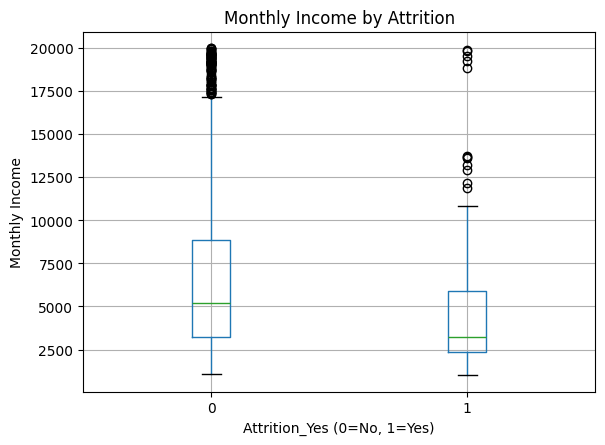

Attrition rate by OverTime_Yes (row-normalized):
 Attrition_Yes         0         1
OverTime_Yes                     
0              0.895636  0.104364
1              0.694712  0.305288


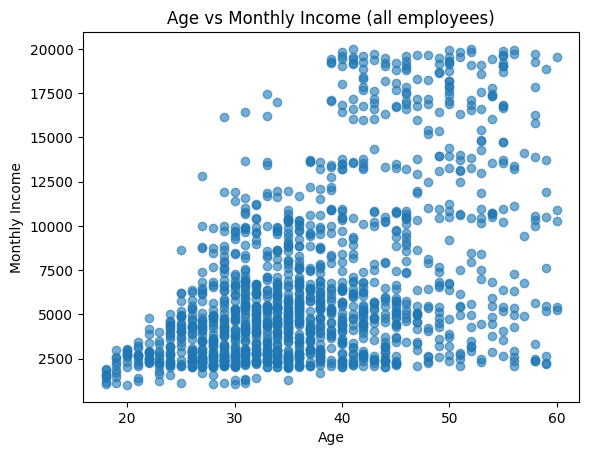

In [ ]:
# --- Bivariate analysis (rubric: box/cross-tab/scatter) ---

# 1) Boxplot: MonthlyIncome by Attrition
plt.figure()
df_clean.boxplot(column="MonthlyIncome", by="Attrition_Yes")
plt.title("Monthly Income by Attrition")
plt.suptitle("")  # removes default pandas subtitle
plt.xlabel("Attrition_Yes (0=No, 1=Yes)")
plt.ylabel("Monthly Income")
plt.show()

# 2) Crosstab: OverTime vs Attrition (rates)
ct = pd.crosstab(df_clean["OverTime_Yes"], df_clean["Attrition_Yes"], normalize="index")
print("Attrition rate by OverTime_Yes (row-normalized):\n", ct)

# 3) Scatter: Age vs MonthlyIncome colored by Attrition
plt.figure()
plt.scatter(df_clean["Age"], df_clean["MonthlyIncome"], alpha=0.6)
plt.title("Age vs Monthly Income (all employees)")
plt.xlabel("Age")
plt.ylabel("Monthly Income")
plt.show()
